In [19]:
import numpy as np
import corner

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = plt.cm.get_cmap('viridis_r')
#cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

## Load data

In [21]:
betas = np.load("../data/betas.npy")
hods = np.load("../data/hods.npy")[:, :-3]
fit_betas = np.load("../data/fit_betas_P+B.npy").T

betas.shape, hods.shape, fit_betas.shape

((10500, 5, 127), (10500, 7), (10500, 6))

## Train density estimators

In [22]:
import torch

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from tqdm import tqdm

In [23]:
val_fraction = 0.05

# Get train and validation sets
n_samples = len(fit_betas)
n_val = int(val_fraction * n_samples)
n_train = n_samples - n_val

# Shuffle data
shuffler = np.random.permutation(n_samples)
fit_betas = fit_betas[shuffler]
hods = hods[shuffler]

X_train = torch.tensor(fit_betas[:n_train], dtype=torch.float32)
Y_train = torch.tensor(hods[:n_train], dtype=torch.float32)

X_val = torch.tensor(fit_betas[n_train:], dtype=torch.float32)
Y_val = torch.tensor(hods[n_train:], dtype=torch.float32)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

(torch.Size([9975, 6]),
 torch.Size([9975, 7]),
 torch.Size([525, 6]),
 torch.Size([525, 7]))

In [24]:
import torch.nn.functional as F

def get_flow(d_in=2, d_context=12, d_hidden=32, n_layers=4, dropout=0.1):
    """ Instantiate a simple (Masked Autoregressive) normalizing flow.
    """

    base_dist = StandardNormal(shape=[d_in])

    transforms = []
    for _ in range(n_layers):
        transforms.append(ReversePermutation(features=d_in))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d_in, 
                                                              hidden_features=d_hidden,
                                                              context_features=d_context,
                                                              use_residual_blocks=True,
                                                              dropout_probability=dropout,
                                                              activation=F.gelu))
        
    transform = CompositeTransform(transforms)

    flow = Flow(transform, base_dist)
    return flow

In [25]:
def train_flow(flow, X, Y, X_val, Y_val, batch_size=64, n_steps=5001, n_eval_every=100, lr = 1e-3):
    """ Convenience function for training the normalizing flow transformation
    """
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

    loss_train = []
    
    loss_train_accum = []
    loss_val_accum = []
    steps_accum = []

    # Run specified number of optimization steps
    for i_step in tqdm(range(n_steps)):
        
        optimizer.zero_grad()
        
        # Draw random batches and compute their log-probability
        idxs = np.random.choice(X.shape[0], batch_size) 
        if Y is not None:
            loss = -flow.log_prob(X[idxs,:], Y[idxs,:]).mean()
        else:
            loss = -flow.log_prob(X[idxs,:]).mean()

        loss.backward()
        optimizer.step()

        # Store loss
        loss_train.append(loss.item())

        # Print progress and validation loss
        if i_step % n_eval_every == 0:
            if Y is not None:
                loss_val = -flow.log_prob(X_val, Y_val).mean()
            else:
                loss_val = -flow.log_prob(X_val).mean()

            loss_train_accum.append(np.mean(loss_train))
            loss_val_accum.append(loss_val.item())
            steps_accum.append(i_step)

            print(f"Step {i_step}, loss: {np.mean(loss_train):.2f}, val loss: {loss_val.item():.2f}")

            loss_train = []

    return steps_accum, loss_train_accum, loss_val_accum
        

## $p(\beta\mid\mathrm{HOD})$

In [26]:
d_in = X_train.shape[-1]
d_context = Y_train.shape[-1]

flow = get_flow(d_in=d_in, d_context=d_context, d_hidden=128, n_layers=6, dropout=0.1)

In [27]:
steps_accum, loss_train_accum, loss_val_accum = train_flow(flow, X_train, Y_train, X_val, Y_val, batch_size=128, n_steps=50001, n_eval_every=200, lr=3e-4)

  0%|          | 10/50001 [00:00<17:09, 48.55it/s]

Step 0, loss: 34.82, val loss: 23.90


  0%|          | 209/50001 [00:03<13:34, 61.15it/s]

Step 200, loss: 0.41, val loss: -2.96


  1%|          | 412/50001 [00:06<13:15, 62.36it/s]

Step 400, loss: -4.17, val loss: -4.17


  1%|          | 608/50001 [00:09<13:13, 62.24it/s]

Step 600, loss: -5.23, val loss: -5.70


  2%|▏         | 811/50001 [00:13<13:16, 61.74it/s]

Step 800, loss: -6.09, val loss: -6.61


  2%|▏         | 1007/50001 [00:16<13:05, 62.34it/s]

Step 1000, loss: -6.59, val loss: -6.90


  2%|▏         | 1210/50001 [00:19<12:54, 63.03it/s]

Step 1200, loss: -6.94, val loss: -7.00


  3%|▎         | 1413/50001 [00:22<12:58, 62.40it/s]

Step 1400, loss: -7.32, val loss: -7.37


  3%|▎         | 1609/50001 [00:25<12:51, 62.69it/s]

Step 1600, loss: -7.59, val loss: -6.51


  4%|▎         | 1812/50001 [00:28<12:44, 63.00it/s]

Step 1800, loss: -7.86, val loss: -7.29


  4%|▍         | 2008/50001 [00:31<12:43, 62.87it/s]

Step 2000, loss: -8.13, val loss: -8.12


  4%|▍         | 2211/50001 [00:35<12:40, 62.82it/s]

Step 2200, loss: -8.27, val loss: -8.49


  5%|▍         | 2414/50001 [00:38<12:37, 62.81it/s]

Step 2400, loss: -8.56, val loss: -8.41


  5%|▌         | 2610/50001 [00:41<12:33, 62.91it/s]

Step 2600, loss: -8.58, val loss: -8.47


  6%|▌         | 2813/50001 [00:44<12:52, 61.06it/s]

Step 2800, loss: -8.80, val loss: -8.96


  6%|▌         | 3009/50001 [00:47<12:28, 62.79it/s]

Step 3000, loss: -8.92, val loss: -9.03


  6%|▋         | 3212/50001 [00:50<12:26, 62.68it/s]

Step 3200, loss: -9.09, val loss: -8.56


  7%|▋         | 3408/50001 [00:53<12:19, 62.97it/s]

Step 3400, loss: -9.16, val loss: -8.92


  7%|▋         | 3611/50001 [00:56<12:14, 63.15it/s]

Step 3600, loss: -9.27, val loss: -9.38


  8%|▊         | 3807/50001 [00:59<12:33, 61.27it/s]

Step 3800, loss: -9.45, val loss: -9.34


  8%|▊         | 4010/50001 [01:03<12:17, 62.36it/s]

Step 4000, loss: -9.50, val loss: -9.72


  8%|▊         | 4213/50001 [01:06<12:11, 62.56it/s]

Step 4200, loss: -9.57, val loss: -9.14


  9%|▉         | 4409/50001 [01:09<12:10, 62.38it/s]

Step 4400, loss: -9.73, val loss: -9.78


  9%|▉         | 4612/50001 [01:12<12:11, 62.05it/s]

Step 4600, loss: -9.81, val loss: -9.89


 10%|▉         | 4808/50001 [01:15<12:00, 62.73it/s]

Step 4800, loss: -9.84, val loss: -10.10


 10%|█         | 5011/50001 [01:18<11:58, 62.66it/s]

Step 5000, loss: -9.99, val loss: -9.86


 10%|█         | 5207/50001 [01:21<12:04, 61.82it/s]

Step 5200, loss: -9.94, val loss: -10.07


 11%|█         | 5410/50001 [01:25<11:55, 62.34it/s]

Step 5400, loss: -10.14, val loss: -10.19


 11%|█         | 5613/50001 [01:28<11:49, 62.53it/s]

Step 5600, loss: -10.18, val loss: -10.19


 12%|█▏        | 5809/50001 [01:31<11:46, 62.52it/s]

Step 5800, loss: -10.24, val loss: -10.38


 12%|█▏        | 6012/50001 [01:34<11:43, 62.51it/s]

Step 6000, loss: -10.36, val loss: -9.92


 12%|█▏        | 6208/50001 [01:37<11:39, 62.62it/s]

Step 6200, loss: -10.49, val loss: -10.75


 13%|█▎        | 6411/50001 [01:40<11:36, 62.62it/s]

Step 6400, loss: -10.51, val loss: -10.57


 13%|█▎        | 6607/50001 [01:43<11:41, 61.90it/s]

Step 6600, loss: -10.56, val loss: -9.58


 14%|█▎        | 6810/50001 [01:47<11:30, 62.52it/s]

Step 6800, loss: -10.58, val loss: -10.86


 14%|█▍        | 7013/50001 [01:50<11:26, 62.66it/s]

Step 7000, loss: -10.64, val loss: -10.31


 14%|█▍        | 7209/50001 [01:53<11:22, 62.71it/s]

Step 7200, loss: -10.76, val loss: -10.94


 15%|█▍        | 7412/50001 [01:56<11:19, 62.64it/s]

Step 7400, loss: -10.80, val loss: -10.81


 15%|█▌        | 7608/50001 [01:59<11:10, 63.21it/s]

Step 7600, loss: -10.93, val loss: -11.10


 16%|█▌        | 7811/50001 [02:02<11:22, 61.80it/s]

Step 7800, loss: -10.91, val loss: -10.99


 16%|█▌        | 8007/50001 [02:05<11:14, 62.24it/s]

Step 8000, loss: -11.00, val loss: -11.10


 16%|█▋        | 8210/50001 [02:08<11:03, 63.01it/s]

Step 8200, loss: -11.00, val loss: -11.18


 17%|█▋        | 8413/50001 [02:12<11:03, 62.67it/s]

Step 8400, loss: -11.11, val loss: -11.27


 17%|█▋        | 8609/50001 [02:15<10:57, 62.97it/s]

Step 8600, loss: -11.14, val loss: -11.15


 18%|█▊        | 8812/50001 [02:18<10:52, 63.12it/s]

Step 8800, loss: -11.11, val loss: -11.39


 18%|█▊        | 9008/50001 [02:21<10:56, 62.45it/s]

Step 9000, loss: -11.24, val loss: -11.09


 18%|█▊        | 9211/50001 [02:24<10:49, 62.76it/s]

Step 9200, loss: -11.27, val loss: -11.32


 19%|█▉        | 9414/50001 [02:27<10:44, 62.93it/s]

Step 9400, loss: -11.28, val loss: -10.90


 19%|█▉        | 9610/50001 [02:30<10:42, 62.88it/s]

Step 9600, loss: -11.37, val loss: -10.82


 20%|█▉        | 9813/50001 [02:33<10:42, 62.53it/s]

Step 9800, loss: -11.35, val loss: -11.48


 20%|██        | 10009/50001 [02:36<10:37, 62.78it/s]

Step 10000, loss: -11.62, val loss: -9.52


 20%|██        | 10212/50001 [02:40<10:33, 62.81it/s]

Step 10200, loss: -11.47, val loss: -11.69


 21%|██        | 10408/50001 [02:43<10:30, 62.77it/s]

Step 10400, loss: -11.53, val loss: -11.17


 21%|██        | 10611/50001 [02:46<10:26, 62.84it/s]

Step 10600, loss: -11.62, val loss: -11.75


 22%|██▏       | 10807/50001 [02:49<10:33, 61.91it/s]

Step 10800, loss: -11.62, val loss: -11.48


 22%|██▏       | 11010/50001 [02:52<10:20, 62.89it/s]

Step 11000, loss: -11.64, val loss: -11.65


 22%|██▏       | 11213/50001 [02:55<10:17, 62.81it/s]

Step 11200, loss: -11.66, val loss: -11.75


 23%|██▎       | 11409/50001 [02:58<10:29, 61.30it/s]

Step 11400, loss: -11.82, val loss: -11.87


 23%|██▎       | 11612/50001 [03:02<10:13, 62.60it/s]

Step 11600, loss: -11.80, val loss: -10.93


 24%|██▎       | 11808/50001 [03:05<10:12, 62.37it/s]

Step 11800, loss: -11.88, val loss: -10.93


 24%|██▍       | 12011/50001 [03:08<10:06, 62.60it/s]

Step 12000, loss: -11.89, val loss: -11.51


 24%|██▍       | 12207/50001 [03:11<10:14, 61.54it/s]

Step 12200, loss: -11.94, val loss: -11.81


 25%|██▍       | 12410/50001 [03:14<10:01, 62.51it/s]

Step 12400, loss: -11.95, val loss: -11.73


 25%|██▌       | 12613/50001 [03:17<10:03, 61.95it/s]

Step 12600, loss: -11.94, val loss: -11.84


 26%|██▌       | 12809/50001 [03:20<09:52, 62.79it/s]

Step 12800, loss: -11.99, val loss: -12.05


 26%|██▌       | 13012/50001 [03:23<09:49, 62.77it/s]

Step 13000, loss: -12.07, val loss: -12.03


 26%|██▋       | 13208/50001 [03:27<09:44, 62.91it/s]

Step 13200, loss: -12.14, val loss: -11.81


 27%|██▋       | 13411/50001 [03:30<09:43, 62.76it/s]

Step 13400, loss: -12.12, val loss: -12.27


 27%|██▋       | 13607/50001 [03:33<09:48, 61.87it/s]

Step 13600, loss: -12.14, val loss: -12.02


 28%|██▊       | 13810/50001 [03:36<09:32, 63.17it/s]

Step 13800, loss: -12.21, val loss: -11.95


 28%|██▊       | 14013/50001 [03:39<09:38, 62.22it/s]

Step 14000, loss: -12.24, val loss: -12.38


 28%|██▊       | 14209/50001 [03:42<09:32, 62.54it/s]

Step 14200, loss: -12.25, val loss: -10.98


 29%|██▉       | 14412/50001 [03:45<09:28, 62.62it/s]

Step 14400, loss: -12.31, val loss: -11.53


 29%|██▉       | 14608/50001 [03:48<09:26, 62.47it/s]

Step 14600, loss: -12.34, val loss: -11.90


 30%|██▉       | 14811/50001 [03:52<09:26, 62.10it/s]

Step 14800, loss: -12.37, val loss: -12.61


 30%|███       | 15007/50001 [03:55<09:32, 61.12it/s]

Step 15000, loss: -12.44, val loss: -12.45


 30%|███       | 15210/50001 [03:58<09:15, 62.61it/s]

Step 15200, loss: -12.47, val loss: -11.07


 31%|███       | 15413/50001 [04:01<09:09, 62.90it/s]

Step 15400, loss: -12.44, val loss: -12.42


 31%|███       | 15609/50001 [04:04<09:04, 63.11it/s]

Step 15600, loss: -12.45, val loss: -12.12


 32%|███▏      | 15812/50001 [04:07<09:02, 63.06it/s]

Step 15800, loss: -12.51, val loss: -12.57


 32%|███▏      | 16008/50001 [04:10<09:04, 62.42it/s]

Step 16000, loss: -12.49, val loss: -12.02


 32%|███▏      | 16211/50001 [04:14<08:56, 62.95it/s]

Step 16200, loss: -12.50, val loss: -12.48


 33%|███▎      | 16407/50001 [04:17<09:03, 61.79it/s]

Step 16400, loss: -12.57, val loss: -12.23


 33%|███▎      | 16610/50001 [04:20<08:54, 62.43it/s]

Step 16600, loss: -12.55, val loss: -12.32


 34%|███▎      | 16813/50001 [04:23<08:51, 62.43it/s]

Step 16800, loss: -12.61, val loss: -12.64


 34%|███▍      | 17009/50001 [04:26<08:45, 62.78it/s]

Step 17000, loss: -12.60, val loss: -12.84


 34%|███▍      | 17212/50001 [04:29<08:47, 62.12it/s]

Step 17200, loss: -12.73, val loss: -12.75


 35%|███▍      | 17408/50001 [04:32<08:47, 61.84it/s]

Step 17400, loss: -12.74, val loss: -12.70


 35%|███▌      | 17611/50001 [04:36<08:39, 62.36it/s]

Step 17600, loss: -12.55, val loss: -12.84


 36%|███▌      | 17814/50001 [04:39<08:31, 62.87it/s]

Step 17800, loss: -12.70, val loss: -11.29


 36%|███▌      | 18010/50001 [04:42<08:30, 62.67it/s]

Step 18000, loss: -12.78, val loss: -12.63


 36%|███▋      | 18213/50001 [04:45<08:27, 62.60it/s]

Step 18200, loss: -12.81, val loss: -13.01


 37%|███▋      | 18409/50001 [04:48<08:24, 62.59it/s]

Step 18400, loss: -12.83, val loss: -12.33


 37%|███▋      | 18612/50001 [04:51<08:21, 62.64it/s]

Step 18600, loss: -12.80, val loss: -12.95


 38%|███▊      | 18808/50001 [04:54<08:17, 62.73it/s]

Step 18800, loss: -12.87, val loss: -11.87


 38%|███▊      | 19011/50001 [04:57<08:14, 62.67it/s]

Step 19000, loss: -12.80, val loss: -12.59


 38%|███▊      | 19207/50001 [05:01<08:19, 61.68it/s]

Step 19200, loss: -12.91, val loss: -12.94


 39%|███▉      | 19410/50001 [05:04<08:07, 62.70it/s]

Step 19400, loss: -12.83, val loss: -12.85


 39%|███▉      | 19613/50001 [05:07<08:04, 62.72it/s]

Step 19600, loss: -13.00, val loss: -13.05


 40%|███▉      | 19809/50001 [05:10<08:07, 61.99it/s]

Step 19800, loss: -12.84, val loss: -13.02


 40%|████      | 20012/50001 [05:13<08:00, 62.38it/s]

Step 20000, loss: -13.02, val loss: -12.94


 40%|████      | 20208/50001 [05:16<07:54, 62.82it/s]

Step 20200, loss: -13.03, val loss: -12.90


 41%|████      | 20411/50001 [05:19<07:55, 62.29it/s]

Step 20400, loss: -12.94, val loss: -12.95


 41%|████      | 20614/50001 [05:23<07:47, 62.82it/s]

Step 20600, loss: -12.93, val loss: -13.01


 42%|████▏     | 20810/50001 [05:26<07:45, 62.75it/s]

Step 20800, loss: -13.11, val loss: -13.15


 42%|████▏     | 21013/50001 [05:29<07:43, 62.49it/s]

Step 21000, loss: -13.00, val loss: -12.94


 42%|████▏     | 21209/50001 [05:32<07:40, 62.47it/s]

Step 21200, loss: -13.10, val loss: -12.50


 43%|████▎     | 21412/50001 [05:35<07:36, 62.60it/s]

Step 21400, loss: -13.09, val loss: -13.18


 43%|████▎     | 21608/50001 [05:38<07:32, 62.71it/s]

Step 21600, loss: -13.21, val loss: -12.97


 44%|████▎     | 21811/50001 [05:41<07:30, 62.60it/s]

Step 21800, loss: -13.06, val loss: -13.36


 44%|████▍     | 22014/50001 [05:45<07:38, 61.08it/s]

Step 22000, loss: -13.21, val loss: -13.26


 44%|████▍     | 22210/50001 [05:48<07:25, 62.39it/s]

Step 22200, loss: -13.19, val loss: -13.33


 45%|████▍     | 22413/50001 [05:51<07:21, 62.49it/s]

Step 22400, loss: -13.17, val loss: -13.21


 45%|████▌     | 22609/50001 [05:54<07:17, 62.65it/s]

Step 22600, loss: -13.29, val loss: -13.30


 46%|████▌     | 22812/50001 [05:57<07:12, 62.84it/s]

Step 22800, loss: -13.10, val loss: -12.71


 46%|████▌     | 23008/50001 [06:00<07:08, 63.02it/s]

Step 23000, loss: -13.26, val loss: -12.92


 46%|████▋     | 23211/50001 [06:03<07:07, 62.63it/s]

Step 23200, loss: -13.23, val loss: -13.33


 47%|████▋     | 23414/50001 [06:06<07:05, 62.55it/s]

Step 23400, loss: -13.20, val loss: -13.36


 47%|████▋     | 23610/50001 [06:10<07:02, 62.49it/s]

Step 23600, loss: -13.35, val loss: -13.25


 48%|████▊     | 23813/50001 [06:13<06:55, 62.98it/s]

Step 23800, loss: -13.26, val loss: -13.13


 48%|████▊     | 24009/50001 [06:16<06:55, 62.56it/s]

Step 24000, loss: -13.31, val loss: -13.10


 48%|████▊     | 24212/50001 [06:19<06:52, 62.47it/s]

Step 24200, loss: -13.39, val loss: -13.57


 49%|████▉     | 24408/50001 [06:22<06:50, 62.38it/s]

Step 24400, loss: -13.33, val loss: -13.20


 49%|████▉     | 24611/50001 [06:25<06:46, 62.45it/s]

Step 24600, loss: -13.37, val loss: -12.45


 50%|████▉     | 24807/50001 [06:28<06:48, 61.71it/s]

Step 24800, loss: -13.37, val loss: -13.40


 50%|█████     | 25010/50001 [06:31<06:40, 62.36it/s]

Step 25000, loss: -13.37, val loss: -13.42


 50%|█████     | 25213/50001 [06:35<06:34, 62.89it/s]

Step 25200, loss: -13.44, val loss: -12.64


 51%|█████     | 25409/50001 [06:38<06:28, 63.25it/s]

Step 25400, loss: -13.54, val loss: -13.20


 51%|█████     | 25612/50001 [06:41<06:28, 62.76it/s]

Step 25600, loss: -12.68, val loss: -13.45


 52%|█████▏    | 25808/50001 [06:44<06:33, 61.43it/s]

Step 25800, loss: -13.55, val loss: -13.41


 52%|█████▏    | 26011/50001 [06:47<06:21, 62.96it/s]

Step 26000, loss: -13.48, val loss: -13.02


 52%|█████▏    | 26207/50001 [06:50<06:20, 62.54it/s]

Step 26200, loss: -13.48, val loss: -13.51


 53%|█████▎    | 26410/50001 [06:53<06:16, 62.74it/s]

Step 26400, loss: -13.52, val loss: -12.91


 53%|█████▎    | 26613/50001 [06:56<06:12, 62.80it/s]

Step 26600, loss: -13.48, val loss: -13.37


 54%|█████▎    | 26809/50001 [07:00<06:10, 62.59it/s]

Step 26800, loss: -13.58, val loss: -12.62


 54%|█████▍    | 27012/50001 [07:03<06:05, 62.91it/s]

Step 27000, loss: -13.52, val loss: -12.95


 54%|█████▍    | 27208/50001 [07:06<06:04, 62.60it/s]

Step 27200, loss: -13.48, val loss: -13.49


 55%|█████▍    | 27411/50001 [07:09<05:59, 62.86it/s]

Step 27400, loss: -13.37, val loss: -10.68


 55%|█████▌    | 27614/50001 [07:12<05:54, 63.18it/s]

Step 27600, loss: -13.50, val loss: -13.04


 56%|█████▌    | 27810/50001 [07:15<05:53, 62.71it/s]

Step 27800, loss: -13.59, val loss: -13.28


 56%|█████▌    | 28013/50001 [07:18<05:51, 62.53it/s]

Step 28000, loss: -13.46, val loss: -13.09


 56%|█████▋    | 28209/50001 [07:21<05:49, 62.35it/s]

Step 28200, loss: -13.55, val loss: -13.51


 57%|█████▋    | 28412/50001 [07:25<05:44, 62.71it/s]

Step 28400, loss: -13.65, val loss: -13.75


 57%|█████▋    | 28608/50001 [07:28<05:43, 62.34it/s]

Step 28600, loss: -13.56, val loss: -13.21


 58%|█████▊    | 28811/50001 [07:31<05:38, 62.62it/s]

Step 28800, loss: -13.66, val loss: -13.69


 58%|█████▊    | 29007/50001 [07:34<05:39, 61.80it/s]

Step 29000, loss: -13.61, val loss: -12.96


 58%|█████▊    | 29210/50001 [07:37<05:31, 62.78it/s]

Step 29200, loss: -13.63, val loss: -13.30


 59%|█████▉    | 29413/50001 [07:40<05:28, 62.63it/s]

Step 29400, loss: -13.60, val loss: -13.31


 59%|█████▉    | 29609/50001 [07:43<05:25, 62.64it/s]

Step 29600, loss: -13.67, val loss: -13.43


 60%|█████▉    | 29812/50001 [07:47<05:22, 62.58it/s]

Step 29800, loss: -13.58, val loss: -13.59


 60%|██████    | 30008/50001 [07:50<05:20, 62.42it/s]

Step 30000, loss: -13.77, val loss: -13.46


 60%|██████    | 30211/50001 [07:53<05:13, 63.17it/s]

Step 30200, loss: -13.41, val loss: -13.40


 61%|██████    | 30407/50001 [07:56<05:17, 61.66it/s]

Step 30400, loss: -13.78, val loss: -13.83


 61%|██████    | 30610/50001 [07:59<05:10, 62.45it/s]

Step 30600, loss: -13.76, val loss: -13.67


 62%|██████▏   | 30813/50001 [08:02<05:06, 62.55it/s]

Step 30800, loss: -13.72, val loss: -13.18


 62%|██████▏   | 31009/50001 [08:05<05:02, 62.80it/s]

Step 31000, loss: -13.77, val loss: -13.89


 62%|██████▏   | 31212/50001 [08:08<05:00, 62.62it/s]

Step 31200, loss: -13.82, val loss: -13.39


 63%|██████▎   | 31408/50001 [08:12<04:56, 62.73it/s]

Step 31400, loss: -13.80, val loss: -13.86


 63%|██████▎   | 31611/50001 [08:15<04:53, 62.66it/s]

Step 31600, loss: -13.74, val loss: -13.33


 64%|██████▎   | 31814/50001 [08:18<04:50, 62.61it/s]

Step 31800, loss: -13.64, val loss: -13.91


 64%|██████▍   | 32010/50001 [08:21<04:47, 62.68it/s]

Step 32000, loss: -13.83, val loss: -13.74


 64%|██████▍   | 32213/50001 [08:24<04:42, 62.87it/s]

Step 32200, loss: -13.76, val loss: -13.89


 65%|██████▍   | 32409/50001 [08:27<04:44, 61.89it/s]

Step 32400, loss: -13.79, val loss: -14.04


 65%|██████▌   | 32612/50001 [08:30<04:37, 62.77it/s]

Step 32600, loss: -13.84, val loss: -14.00


 66%|██████▌   | 32808/50001 [08:33<04:35, 62.41it/s]

Step 32800, loss: -13.91, val loss: -13.72


 66%|██████▌   | 33011/50001 [08:37<04:31, 62.67it/s]

Step 33000, loss: -13.74, val loss: -14.05


 66%|██████▋   | 33207/50001 [08:40<04:32, 61.73it/s]

Step 33200, loss: -13.89, val loss: -13.73


 67%|██████▋   | 33410/50001 [08:43<04:24, 62.73it/s]

Step 33400, loss: -13.93, val loss: -13.50


 67%|██████▋   | 33613/50001 [08:46<04:18, 63.28it/s]

Step 33600, loss: -13.96, val loss: -14.04


 68%|██████▊   | 33809/50001 [08:49<04:17, 62.90it/s]

Step 33800, loss: -13.82, val loss: -13.73


 68%|██████▊   | 34012/50001 [08:52<04:15, 62.58it/s]

Step 34000, loss: -14.01, val loss: -13.06


 68%|██████▊   | 34208/50001 [08:55<04:14, 62.15it/s]

Step 34200, loss: -14.00, val loss: -14.23


 69%|██████▉   | 34411/50001 [08:58<04:06, 63.26it/s]

Step 34400, loss: -13.96, val loss: -13.38


 69%|██████▉   | 34607/50001 [09:02<04:08, 62.05it/s]

Step 34600, loss: -13.84, val loss: -14.01


 70%|██████▉   | 34810/50001 [09:05<04:01, 62.85it/s]

Step 34800, loss: -13.99, val loss: -13.37


 70%|███████   | 35013/50001 [09:08<03:59, 62.64it/s]

Step 35000, loss: -14.01, val loss: -13.68


 70%|███████   | 35209/50001 [09:11<03:55, 62.74it/s]

Step 35200, loss: -13.87, val loss: -14.08


 71%|███████   | 35412/50001 [09:14<03:52, 62.75it/s]

Step 35400, loss: -13.94, val loss: -13.93


 71%|███████   | 35608/50001 [09:17<03:49, 62.70it/s]

Step 35600, loss: -14.03, val loss: -13.56


 72%|███████▏  | 35811/50001 [09:20<03:47, 62.43it/s]

Step 35800, loss: -13.98, val loss: -13.98


 72%|███████▏  | 36014/50001 [09:24<03:42, 62.81it/s]

Step 36000, loss: -14.05, val loss: -13.85


 72%|███████▏  | 36210/50001 [09:27<03:39, 62.84it/s]

Step 36200, loss: -13.95, val loss: -13.36


 73%|███████▎  | 36413/50001 [09:30<03:37, 62.47it/s]

Step 36400, loss: -14.07, val loss: -13.75


 73%|███████▎  | 36609/50001 [09:33<03:36, 61.89it/s]

Step 36600, loss: -14.07, val loss: -14.03


 74%|███████▎  | 36812/50001 [09:36<03:32, 62.09it/s]

Step 36800, loss: -13.94, val loss: -14.02


 74%|███████▍  | 37008/50001 [09:39<03:27, 62.58it/s]

Step 37000, loss: -13.85, val loss: -14.08


 74%|███████▍  | 37211/50001 [09:42<03:25, 62.23it/s]

Step 37200, loss: -14.05, val loss: -14.10


 75%|███████▍  | 37414/50001 [09:46<03:20, 62.67it/s]

Step 37400, loss: -14.06, val loss: -14.23


 75%|███████▌  | 37610/50001 [09:49<03:18, 62.42it/s]

Step 37600, loss: -14.16, val loss: -14.10


 76%|███████▌  | 37813/50001 [09:52<03:14, 62.53it/s]

Step 37800, loss: -14.06, val loss: -13.87


 76%|███████▌  | 38009/50001 [09:55<03:10, 63.05it/s]

Step 38000, loss: -14.13, val loss: -13.91


 76%|███████▋  | 38212/50001 [09:58<03:07, 62.92it/s]

Step 38200, loss: -14.07, val loss: -13.72


 77%|███████▋  | 38408/50001 [10:01<03:03, 63.13it/s]

Step 38400, loss: -14.11, val loss: -14.07


 77%|███████▋  | 38611/50001 [10:04<02:59, 63.31it/s]

Step 38600, loss: -14.23, val loss: -14.16


 78%|███████▊  | 38814/50001 [10:07<02:57, 62.90it/s]

Step 38800, loss: -14.21, val loss: -14.09


 78%|███████▊  | 39010/50001 [10:10<02:55, 62.72it/s]

Step 39000, loss: -14.13, val loss: -14.39


 78%|███████▊  | 39213/50001 [10:14<02:52, 62.55it/s]

Step 39200, loss: -13.98, val loss: -13.94


 79%|███████▉  | 39409/50001 [10:17<02:48, 62.84it/s]

Step 39400, loss: -14.26, val loss: -12.09


 79%|███████▉  | 39612/50001 [10:20<02:45, 62.83it/s]

Step 39600, loss: -14.22, val loss: -13.18


 80%|███████▉  | 39808/50001 [10:23<02:44, 61.88it/s]

Step 39800, loss: -14.15, val loss: -13.82


 80%|████████  | 40011/50001 [10:26<02:39, 62.59it/s]

Step 40000, loss: -14.08, val loss: -14.24


 80%|████████  | 40214/50001 [10:29<02:35, 62.91it/s]

Step 40200, loss: -14.14, val loss: -13.82


 81%|████████  | 40410/50001 [10:32<02:32, 63.00it/s]

Step 40400, loss: -14.36, val loss: -14.03


 81%|████████  | 40613/50001 [10:36<02:29, 62.90it/s]

Step 40600, loss: -14.11, val loss: -13.96


 82%|████████▏ | 40809/50001 [10:39<02:27, 62.31it/s]

Step 40800, loss: -14.23, val loss: -13.78


 82%|████████▏ | 41012/50001 [10:42<02:23, 62.61it/s]

Step 41000, loss: -14.18, val loss: -14.23


 82%|████████▏ | 41208/50001 [10:45<02:20, 62.52it/s]

Step 41200, loss: -14.36, val loss: -14.30


 83%|████████▎ | 41411/50001 [10:48<02:17, 62.53it/s]

Step 41400, loss: -14.13, val loss: -14.25


 83%|████████▎ | 41607/50001 [10:51<02:15, 62.06it/s]

Step 41600, loss: -14.22, val loss: -14.01


 84%|████████▎ | 41810/50001 [10:54<02:11, 62.29it/s]

Step 41800, loss: -14.32, val loss: -13.93


 84%|████████▍ | 42013/50001 [10:58<02:07, 62.44it/s]

Step 42000, loss: -14.17, val loss: -13.15


 84%|████████▍ | 42209/50001 [11:01<02:04, 62.77it/s]

Step 42200, loss: -14.31, val loss: -13.05


 85%|████████▍ | 42412/50001 [11:04<02:00, 62.81it/s]

Step 42400, loss: -14.36, val loss: -14.24


 85%|████████▌ | 42608/50001 [11:07<01:58, 62.40it/s]

Step 42600, loss: -14.15, val loss: -14.12


 86%|████████▌ | 42811/50001 [11:10<01:55, 62.47it/s]

Step 42800, loss: -14.26, val loss: -14.10


 86%|████████▌ | 43007/50001 [11:13<01:52, 62.14it/s]

Step 43000, loss: -14.33, val loss: -13.84


 86%|████████▋ | 43210/50001 [11:16<01:48, 62.64it/s]

Step 43200, loss: -14.22, val loss: -14.26


 87%|████████▋ | 43413/50001 [11:19<01:45, 62.23it/s]

Step 43400, loss: -14.44, val loss: -14.57


 87%|████████▋ | 43609/50001 [11:23<01:42, 62.46it/s]

Step 43600, loss: -14.44, val loss: -13.65


 88%|████████▊ | 43812/50001 [11:26<01:38, 62.93it/s]

Step 43800, loss: -14.37, val loss: -14.15


 88%|████████▊ | 44008/50001 [11:29<01:35, 62.92it/s]

Step 44000, loss: -14.37, val loss: -14.24


 88%|████████▊ | 44211/50001 [11:32<01:32, 62.46it/s]

Step 44200, loss: -14.27, val loss: -13.64


 89%|████████▉ | 44407/50001 [11:35<01:30, 61.93it/s]

Step 44400, loss: -14.37, val loss: -13.84


 89%|████████▉ | 44610/50001 [11:38<01:25, 62.91it/s]

Step 44600, loss: -14.38, val loss: -14.37


 90%|████████▉ | 44813/50001 [11:41<01:22, 62.57it/s]

Step 44800, loss: -14.33, val loss: -14.26


 90%|█████████ | 45009/50001 [11:44<01:20, 62.38it/s]

Step 45000, loss: -13.80, val loss: -13.22


 90%|█████████ | 45212/50001 [11:48<01:16, 62.58it/s]

Step 45200, loss: -14.41, val loss: -14.25


 91%|█████████ | 45408/50001 [11:51<01:13, 62.60it/s]

Step 45400, loss: -14.50, val loss: -14.03


 91%|█████████ | 45611/50001 [11:54<01:09, 62.80it/s]

Step 45600, loss: -14.50, val loss: -13.61


 92%|█████████▏| 45814/50001 [11:57<01:07, 62.44it/s]

Step 45800, loss: -14.32, val loss: -14.43


 92%|█████████▏| 46010/50001 [12:00<01:03, 62.54it/s]

Step 46000, loss: -14.46, val loss: -14.11


 92%|█████████▏| 46213/50001 [12:03<01:00, 62.56it/s]

Step 46200, loss: -14.51, val loss: -14.46


 93%|█████████▎| 46409/50001 [12:06<00:57, 62.55it/s]

Step 46400, loss: -14.33, val loss: -13.95


 93%|█████████▎| 46612/50001 [12:10<00:54, 62.72it/s]

Step 46600, loss: -14.46, val loss: -14.27


 94%|█████████▎| 46808/50001 [12:13<00:50, 62.94it/s]

Step 46800, loss: -14.41, val loss: -14.48


 94%|█████████▍| 47011/50001 [12:16<00:47, 63.03it/s]

Step 47000, loss: -14.57, val loss: -14.01


 94%|█████████▍| 47214/50001 [12:19<00:44, 62.85it/s]

Step 47200, loss: -14.51, val loss: -13.59


 95%|█████████▍| 47410/50001 [12:22<00:41, 62.36it/s]

Step 47400, loss: -14.52, val loss: -13.95


 95%|█████████▌| 47613/50001 [12:25<00:38, 62.44it/s]

Step 47600, loss: -14.50, val loss: -14.36


 96%|█████████▌| 47809/50001 [12:28<00:35, 62.55it/s]

Step 47800, loss: -14.45, val loss: -14.09


 96%|█████████▌| 48012/50001 [12:31<00:31, 62.54it/s]

Step 48000, loss: -14.57, val loss: -14.43


 96%|█████████▋| 48208/50001 [12:35<00:28, 62.41it/s]

Step 48200, loss: -14.48, val loss: -14.25


 97%|█████████▋| 48411/50001 [12:38<00:25, 62.53it/s]

Step 48400, loss: -12.28, val loss: -13.21


 97%|█████████▋| 48607/50001 [12:41<00:22, 61.81it/s]

Step 48600, loss: -14.23, val loss: -14.10


 98%|█████████▊| 48810/50001 [12:44<00:18, 62.97it/s]

Step 48800, loss: -14.63, val loss: -14.53


 98%|█████████▊| 49013/50001 [12:47<00:15, 63.57it/s]

Step 49000, loss: -14.63, val loss: -14.27


 98%|█████████▊| 49209/50001 [12:50<00:12, 62.95it/s]

Step 49200, loss: -14.58, val loss: -14.36


 99%|█████████▉| 49412/50001 [12:53<00:09, 62.33it/s]

Step 49400, loss: -14.53, val loss: -13.98


 99%|█████████▉| 49608/50001 [12:56<00:06, 62.57it/s]

Step 49600, loss: -14.59, val loss: -14.70


100%|█████████▉| 49811/50001 [13:00<00:03, 61.70it/s]

Step 49800, loss: -14.56, val loss: -13.48


100%|██████████| 50001/50001 [13:03<00:00, 63.85it/s]

Step 50000, loss: -14.52, val loss: -14.16


In [28]:
flow.eval();

In [29]:
Y_val.mean(axis=0), Y_val.std(axis=0)

(tensor([ 1.2846e+01,  1.3801e+01, -1.5030e+00,  1.0978e+00,  7.3152e-01,
         -2.1922e-02,  4.9808e-03]),
 tensor([0.2708, 0.3573, 0.8546, 0.2349, 0.4332, 0.2825, 0.5944]))

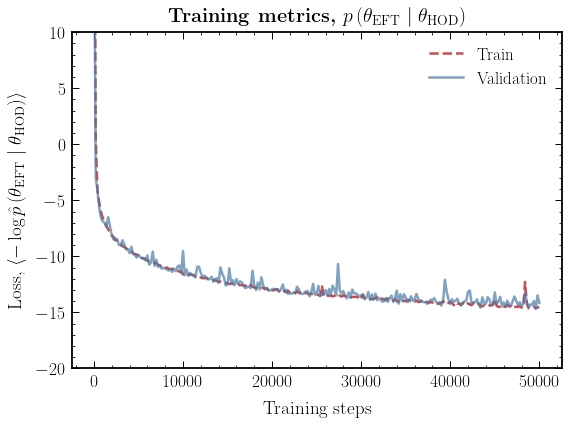

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(steps_accum, loss_train_accum, label="Train", ls='--')
ax.plot(steps_accum, loss_val_accum, label="Validation", alpha=0.7)
ax.set_xlabel("Training steps")
ax.set_ylabel(r"Loss, $\langle -\log \hat p\left(\theta_\mathrm{EFT}\mid\theta_\mathrm{HOD}\right)\rangle$")

ax.legend()
ax.set_title(r"\bf{Training metrics, $p\left(\theta_\mathrm{EFT}\mid\theta_\mathrm{HOD}\right)$}", y=1.01, fontsize=20)

ax.set_ylim(-20, 10)
plt.tight_layout()
plt.savefig("figures/loss_p_eft_hod.pdf")

In [31]:
samples_1 = flow.sample(context=(Y_val.mean(0) - 0 * Y_val.std(0)) [None, ...], num_samples=100_000)
samples_2 = flow.sample(context=(Y_val.mean(0) + 1 * Y_val.std(0)) [None, ...], num_samples=100_000)

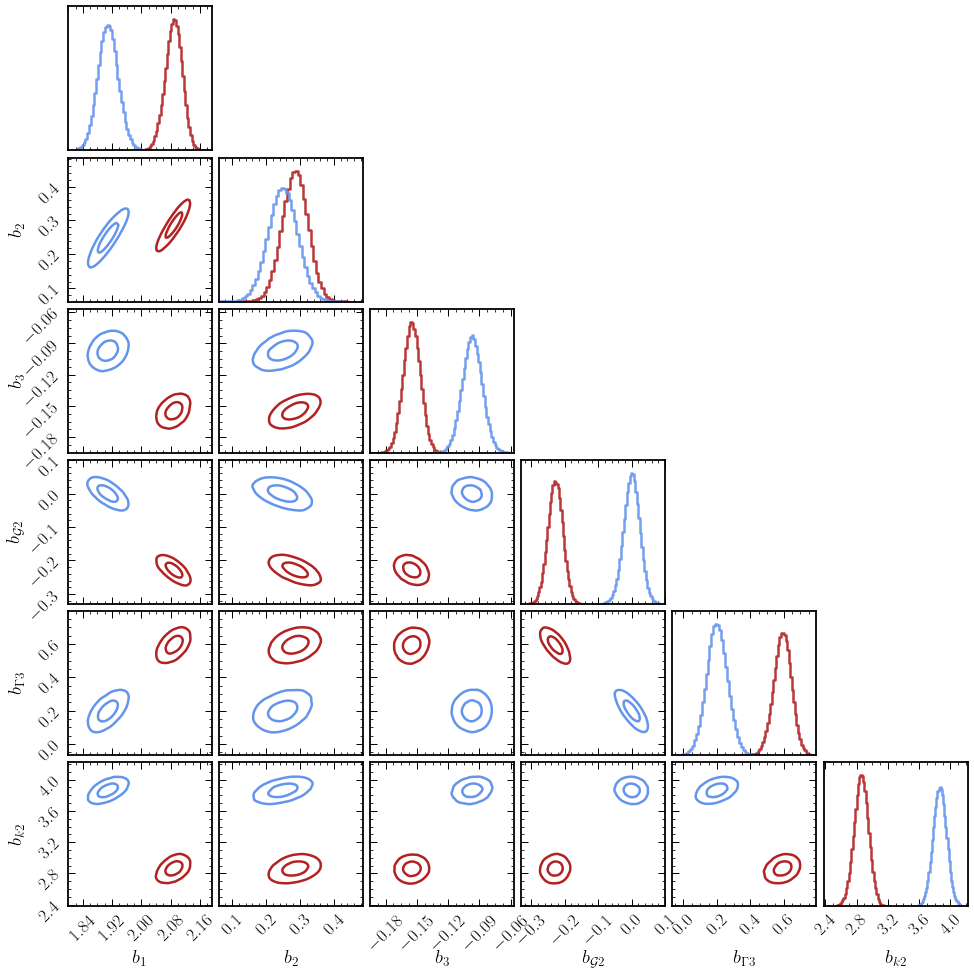

In [32]:
levels =  1.0 - np.exp(-0.5 *np.array([1.0, 2.0]) ** 2)

corner_configs = {
    "smooth": 1.,
    "smooth1d": 0.75,
    "bins": 50,
    "levels": levels, # Assuming 'levels' is defined elsewhere
    "plot_datapoints": False,
    "plot_density": False,
    "labels": [r'$b_1$', r'$b_2$', r'$b_3$', r'$b_{\mathcal G2}$', r'$b_{\Gamma3}$', r'$b_{k2}$']
}

fig = corner.corner(samples_1.detach().numpy(), **corner_configs, color='firebrick');
corner.corner(samples_2.detach().numpy(), **corner_configs, fig=fig, color='cornflowerblue');

In [33]:
torch.save(flow, "../data/models/p_beta_hod.pt")

## $p(\beta)$

In [34]:
fit_betas.shape

(10500, 6)

In [35]:
# remove b3 and bk2 (index 2 and 5) from betas
fit_betas = fit_betas[:, [0, 1, 3, 4]]

In [36]:
d_in = X_train.shape[-1]

flow = get_flow(d_in=d_in, d_context=0, d_hidden=64, n_layers=6, dropout=0.1)
steps_accum, loss_train_accum, loss_val_accum = train_flow(flow, X_train, None, X_val, None, batch_size=128, n_steps=30001, n_eval_every=200, lr=3e-4)

/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
  0%|          | 21/30001 [00:00<04:47, 104.45it/s]

Step 0, loss: 18.84, val loss: 18.68


  1%|          | 216/30001 [00:01<03:45, 131.79it/s]

Step 200, loss: 5.72, val loss: -0.90


  1%|▏         | 426/30001 [00:03<03:42, 132.89it/s]

Step 400, loss: -1.80, val loss: -2.43


  2%|▏         | 622/30001 [00:04<03:42, 131.98it/s]

Step 600, loss: -2.51, val loss: -2.46


  3%|▎         | 818/30001 [00:06<03:39, 132.65it/s]

Step 800, loss: -2.72, val loss: -2.84


  3%|▎         | 1027/30001 [00:07<03:37, 133.07it/s]

Step 1000, loss: -2.88, val loss: -2.89


  4%|▍         | 1223/30001 [00:09<03:37, 132.35it/s]

Step 1200, loss: -2.96, val loss: -2.89


  5%|▍         | 1420/30001 [00:10<03:29, 136.56it/s]

Step 1400, loss: -3.04, val loss: -3.00


  5%|▌         | 1617/30001 [00:12<03:28, 136.34it/s]

Step 1600, loss: -3.13, val loss: -3.09


  6%|▌         | 1828/30001 [00:13<03:29, 134.45it/s]

Step 1800, loss: -3.14, val loss: -3.12


  7%|▋         | 2024/30001 [00:15<03:29, 133.70it/s]

Step 2000, loss: -3.16, val loss: -3.10


  7%|▋         | 2222/30001 [00:16<03:23, 136.40it/s]

Step 2200, loss: -3.20, val loss: -3.23


  8%|▊         | 2418/30001 [00:17<03:23, 135.84it/s]

Step 2400, loss: -3.26, val loss: -3.24


  9%|▉         | 2629/30001 [00:19<03:20, 136.76it/s]

Step 2600, loss: -3.28, val loss: -3.18


  9%|▉         | 2828/30001 [00:20<03:18, 137.07it/s]

Step 2800, loss: -3.28, val loss: -3.28


 10%|█         | 3028/30001 [00:22<03:16, 137.61it/s]

Step 3000, loss: -3.31, val loss: -3.29


 11%|█         | 3227/30001 [00:23<03:16, 136.24it/s]

Step 3200, loss: -3.34, val loss: -3.37


 11%|█▏        | 3426/30001 [00:25<03:14, 136.86it/s]

Step 3400, loss: -3.35, val loss: -3.37


 12%|█▏        | 3624/30001 [00:26<03:17, 133.69it/s]

Step 3600, loss: -3.38, val loss: -3.17


 13%|█▎        | 3823/30001 [00:28<03:12, 135.84it/s]

Step 3800, loss: -3.38, val loss: -3.40


 13%|█▎        | 4023/30001 [00:29<03:09, 136.79it/s]

Step 4000, loss: -3.44, val loss: -3.36


 14%|█▍        | 4221/30001 [00:31<03:07, 137.35it/s]

Step 4200, loss: -3.40, val loss: -3.44


 15%|█▍        | 4418/30001 [00:32<03:11, 133.73it/s]

Step 4400, loss: -3.44, val loss: -3.47


 15%|█▌        | 4617/30001 [00:33<03:06, 136.05it/s]

Step 4600, loss: -3.47, val loss: -3.36


 16%|█▌        | 4817/30001 [00:35<03:04, 136.78it/s]

Step 4800, loss: -3.47, val loss: -3.52


 17%|█▋        | 5028/30001 [00:36<03:05, 134.40it/s]

Step 5000, loss: -3.52, val loss: -3.53


 17%|█▋        | 5217/30001 [00:38<03:17, 125.44it/s]

Step 5200, loss: -3.53, val loss: -3.48


 18%|█▊        | 5416/30001 [00:39<03:01, 135.79it/s]

Step 5400, loss: -3.52, val loss: -3.51


 19%|█▊        | 5618/30001 [00:41<02:57, 137.14it/s]

Step 5600, loss: -3.50, val loss: -3.56


 19%|█▉        | 5816/30001 [00:42<02:58, 135.82it/s]

Step 5800, loss: -3.54, val loss: -3.58


 20%|██        | 6015/30001 [00:44<02:54, 137.21it/s]

Step 6000, loss: -3.54, val loss: -3.54


 21%|██        | 6221/30001 [00:45<02:53, 136.84it/s]

Step 6200, loss: -3.59, val loss: -3.57


 21%|██▏       | 6420/30001 [00:47<02:51, 137.18it/s]

Step 6400, loss: -3.58, val loss: -3.57


 22%|██▏       | 6620/30001 [00:48<02:50, 137.10it/s]

Step 6600, loss: -3.59, val loss: -3.45


 23%|██▎       | 6817/30001 [00:50<02:49, 136.79it/s]

Step 6800, loss: -3.61, val loss: -3.64


 23%|██▎       | 7021/30001 [00:51<02:49, 135.68it/s]

Step 7000, loss: -3.59, val loss: -3.62


 24%|██▍       | 7222/30001 [00:52<02:46, 137.02it/s]

Step 7200, loss: -3.63, val loss: -3.62


 25%|██▍       | 7420/30001 [00:54<02:44, 137.48it/s]

Step 7400, loss: -3.65, val loss: -3.58


 25%|██▌       | 7619/30001 [00:55<02:43, 136.71it/s]

Step 7600, loss: -3.64, val loss: -3.61


 26%|██▌       | 7817/30001 [00:57<02:48, 132.02it/s]

Step 7800, loss: -3.66, val loss: -3.67


 27%|██▋       | 8016/30001 [00:58<02:42, 135.28it/s]

Step 8000, loss: -3.64, val loss: -3.70


 27%|██▋       | 8228/30001 [01:00<02:38, 136.99it/s]

Step 8200, loss: -3.67, val loss: -3.67


 28%|██▊       | 8416/30001 [01:01<02:37, 137.36it/s]

Step 8400, loss: -3.68, val loss: -3.68


 29%|██▉       | 8626/30001 [01:03<02:39, 133.93it/s]

Step 8600, loss: -3.71, val loss: -3.66


 29%|██▉       | 8823/30001 [01:04<02:36, 135.29it/s]

Step 8800, loss: -3.71, val loss: -3.74


 30%|███       | 9021/30001 [01:06<02:33, 136.72it/s]

Step 9000, loss: -3.70, val loss: -3.69


 31%|███       | 9217/30001 [01:07<02:32, 136.15it/s]

Step 9200, loss: -3.71, val loss: -3.77


 31%|███▏      | 9415/30001 [01:08<02:30, 137.11it/s]

Step 9400, loss: -3.70, val loss: -3.66


 32%|███▏      | 9627/30001 [01:10<02:28, 136.77it/s]

Step 9600, loss: -3.71, val loss: -3.78


 33%|███▎      | 9826/30001 [01:11<02:28, 136.06it/s]

Step 9800, loss: -3.75, val loss: -3.67


 33%|███▎      | 10022/30001 [01:13<02:27, 135.42it/s]

Step 10000, loss: -3.74, val loss: -3.75


 34%|███▍      | 10218/30001 [01:14<02:25, 135.61it/s]

Step 10200, loss: -3.73, val loss: -3.77


 35%|███▍      | 10415/30001 [01:16<02:23, 136.71it/s]

Step 10400, loss: -3.75, val loss: -3.71


 35%|███▌      | 10626/30001 [01:17<02:21, 137.00it/s]

Step 10600, loss: -3.73, val loss: -3.72


 36%|███▌      | 10824/30001 [01:19<02:21, 135.45it/s]

Step 10800, loss: -3.78, val loss: -3.70


 37%|███▋      | 11023/30001 [01:20<02:19, 136.22it/s]

Step 11000, loss: -3.76, val loss: -3.79


 37%|███▋      | 11222/30001 [01:22<02:17, 136.66it/s]

Step 11200, loss: -3.76, val loss: -3.83


 38%|███▊      | 11420/30001 [01:23<02:15, 136.99it/s]

Step 11400, loss: -3.76, val loss: -3.80


 39%|███▊      | 11619/30001 [01:25<02:14, 136.73it/s]

Step 11600, loss: -3.76, val loss: -3.79


 39%|███▉      | 11816/30001 [01:26<02:13, 136.69it/s]

Step 11800, loss: -3.75, val loss: -3.72


 40%|████      | 12026/30001 [01:27<02:12, 135.34it/s]

Step 12000, loss: -3.81, val loss: -3.76


 41%|████      | 12224/30001 [01:29<02:09, 137.37it/s]

Step 12200, loss: -3.82, val loss: -3.86


 41%|████▏     | 12420/30001 [01:30<02:15, 130.08it/s]

Step 12400, loss: -3.81, val loss: -3.73


 42%|████▏     | 12619/30001 [01:32<02:07, 135.99it/s]

Step 12600, loss: -3.82, val loss: -3.82


 43%|████▎     | 12820/30001 [01:33<02:05, 136.86it/s]

Step 12800, loss: -3.82, val loss: -3.80


 43%|████▎     | 13019/30001 [01:35<02:03, 137.26it/s]

Step 13000, loss: -3.83, val loss: -3.84


 44%|████▍     | 13220/30001 [01:36<02:02, 137.20it/s]

Step 13200, loss: -3.81, val loss: -3.76


 45%|████▍     | 13422/30001 [01:38<02:02, 135.13it/s]

Step 13400, loss: -3.86, val loss: -3.80


 45%|████▌     | 13622/30001 [01:39<02:00, 136.21it/s]

Step 13600, loss: -3.83, val loss: -3.70


 46%|████▌     | 13821/30001 [01:41<01:59, 135.81it/s]

Step 13800, loss: -3.83, val loss: -3.88


 47%|████▋     | 14019/30001 [01:42<01:56, 136.62it/s]

Step 14000, loss: -3.87, val loss: -3.87


 47%|████▋     | 14222/30001 [01:44<01:54, 137.74it/s]

Step 14200, loss: -3.85, val loss: -3.85


 48%|████▊     | 14420/30001 [01:45<01:54, 136.10it/s]

Step 14400, loss: -3.83, val loss: -3.78


 49%|████▉     | 14626/30001 [01:46<01:50, 138.75it/s]

Step 14600, loss: -3.86, val loss: -3.80


 49%|████▉     | 14827/30001 [01:48<01:50, 136.94it/s]

Step 14800, loss: -3.86, val loss: -3.88


 50%|█████     | 15027/30001 [01:49<01:49, 137.08it/s]

Step 15000, loss: -3.88, val loss: -3.75


 51%|█████     | 15229/30001 [01:51<01:47, 137.27it/s]

Step 15200, loss: -3.86, val loss: -3.87


 51%|█████▏    | 15424/30001 [01:52<01:54, 127.50it/s]

Step 15400, loss: -3.86, val loss: -3.80


 52%|█████▏    | 15623/30001 [01:54<01:45, 136.89it/s]

Step 15600, loss: -3.87, val loss: -3.91


 53%|█████▎    | 15828/30001 [01:55<01:42, 138.65it/s]

Step 15800, loss: -3.91, val loss: -3.85


 53%|█████▎    | 16014/30001 [01:57<01:48, 128.71it/s]

Step 16000, loss: -3.91, val loss: -3.92


 54%|█████▍    | 16216/30001 [01:58<01:39, 138.31it/s]

Step 16200, loss: -3.89, val loss: -3.91


 55%|█████▍    | 16415/30001 [02:00<01:39, 136.45it/s]

Step 16400, loss: -3.90, val loss: -3.81


 55%|█████▌    | 16619/30001 [02:01<01:37, 137.68it/s]

Step 16600, loss: -3.92, val loss: -3.89


 56%|█████▌    | 16821/30001 [02:02<01:36, 137.29it/s]

Step 16800, loss: -3.90, val loss: -3.85


 57%|█████▋    | 17020/30001 [02:04<01:35, 136.62it/s]

Step 17000, loss: -3.93, val loss: -3.91


 57%|█████▋    | 17217/30001 [02:05<01:33, 137.21it/s]

Step 17200, loss: -3.91, val loss: -3.74


 58%|█████▊    | 17417/30001 [02:07<01:31, 138.22it/s]

Step 17400, loss: -3.91, val loss: -3.92


 59%|█████▊    | 17617/30001 [02:08<01:29, 137.86it/s]

Step 17600, loss: -3.92, val loss: -3.88


 59%|█████▉    | 17829/30001 [02:10<01:28, 137.28it/s]

Step 17800, loss: -3.91, val loss: -3.94


 60%|██████    | 18016/30001 [02:11<01:30, 132.43it/s]

Step 18000, loss: -3.92, val loss: -3.95


 61%|██████    | 18216/30001 [02:13<01:25, 137.21it/s]

Step 18200, loss: -3.95, val loss: -3.95


 61%|██████▏   | 18416/30001 [02:14<01:24, 137.27it/s]

Step 18400, loss: -3.93, val loss: -3.92


 62%|██████▏   | 18620/30001 [02:16<01:22, 137.37it/s]

Step 18600, loss: -3.97, val loss: -3.92


 63%|██████▎   | 18825/30001 [02:17<01:21, 137.32it/s]

Step 18800, loss: -3.96, val loss: -3.91


 63%|██████▎   | 19028/30001 [02:19<01:20, 135.83it/s]

Step 19000, loss: -3.96, val loss: -3.98


 64%|██████▍   | 19218/30001 [02:20<01:18, 138.09it/s]

Step 19200, loss: -3.93, val loss: -3.92


 65%|██████▍   | 19418/30001 [02:21<01:17, 136.55it/s]

Step 19400, loss: -3.93, val loss: -3.93


 65%|██████▌   | 19620/30001 [02:23<01:15, 137.27it/s]

Step 19600, loss: -3.94, val loss: -3.95


 66%|██████▌   | 19823/30001 [02:24<01:13, 137.96it/s]

Step 19800, loss: -3.98, val loss: -3.91


 67%|██████▋   | 20023/30001 [02:26<01:12, 136.93it/s]

Step 20000, loss: -3.97, val loss: -3.92


 67%|██████▋   | 20222/30001 [02:27<01:11, 135.98it/s]

Step 20200, loss: -4.00, val loss: -3.96


 68%|██████▊   | 20423/30001 [02:29<01:09, 137.93it/s]

Step 20400, loss: -3.97, val loss: -3.89


 69%|██████▉   | 20628/30001 [02:30<01:07, 138.27it/s]

Step 20600, loss: -3.98, val loss: -4.01


 69%|██████▉   | 20820/30001 [02:31<01:06, 138.31it/s]

Step 20800, loss: -3.98, val loss: -3.94


 70%|███████   | 21022/30001 [02:33<01:05, 137.51it/s]

Step 21000, loss: -3.98, val loss: -3.95


 71%|███████   | 21225/30001 [02:34<01:04, 137.05it/s]

Step 21200, loss: -3.96, val loss: -3.98


 71%|███████▏  | 21427/30001 [02:36<01:02, 136.40it/s]

Step 21400, loss: -3.98, val loss: -3.99


 72%|███████▏  | 21629/30001 [02:37<01:00, 138.06it/s]

Step 21600, loss: -4.00, val loss: -3.98


 73%|███████▎  | 21815/30001 [02:39<01:00, 134.82it/s]

Step 21800, loss: -4.01, val loss: -3.97


 73%|███████▎  | 22017/30001 [02:40<00:58, 137.13it/s]

Step 22000, loss: -4.05, val loss: -3.96


 74%|███████▍  | 22218/30001 [02:42<00:56, 137.65it/s]

Step 22200, loss: -3.99, val loss: -3.96


 75%|███████▍  | 22418/30001 [02:43<00:55, 137.19it/s]

Step 22400, loss: -4.03, val loss: -3.88


 75%|███████▌  | 22620/30001 [02:44<00:53, 137.13it/s]

Step 22600, loss: -4.00, val loss: -4.00


 76%|███████▌  | 22821/30001 [02:46<00:52, 136.86it/s]

Step 22800, loss: -4.00, val loss: -3.95


 77%|███████▋  | 23020/30001 [02:47<00:50, 138.19it/s]

Step 23000, loss: -4.01, val loss: -3.99


 77%|███████▋  | 23221/30001 [02:49<00:50, 135.23it/s]

Step 23200, loss: -3.98, val loss: -3.99


 78%|███████▊  | 23424/30001 [02:50<00:47, 138.14it/s]

Step 23400, loss: -4.00, val loss: -3.99


 79%|███████▊  | 23615/30001 [02:52<00:47, 133.80it/s]

Step 23600, loss: -4.01, val loss: -3.97


 79%|███████▉  | 23828/30001 [02:53<00:45, 136.11it/s]

Step 23800, loss: -4.00, val loss: -3.76


 80%|████████  | 24018/30001 [02:55<00:43, 137.33it/s]

Step 24000, loss: -4.02, val loss: -3.98


 81%|████████  | 24220/30001 [02:56<00:43, 133.51it/s]

Step 24200, loss: -4.09, val loss: -3.99


 81%|████████▏ | 24417/30001 [02:58<00:41, 135.26it/s]

Step 24400, loss: -4.02, val loss: -4.02


 82%|████████▏ | 24618/30001 [02:59<00:39, 137.16it/s]

Step 24600, loss: -4.02, val loss: -4.01


 83%|████████▎ | 24819/30001 [03:00<00:37, 136.68it/s]

Step 24800, loss: -4.04, val loss: -4.02


 83%|████████▎ | 25024/30001 [03:02<00:36, 137.01it/s]

Step 25000, loss: -4.04, val loss: -3.94


 84%|████████▍ | 25215/30001 [03:03<00:34, 137.15it/s]

Step 25200, loss: -4.04, val loss: -4.03


 85%|████████▍ | 25419/30001 [03:05<00:33, 134.81it/s]

Step 25400, loss: -4.02, val loss: -4.03


 85%|████████▌ | 25625/30001 [03:06<00:31, 138.33it/s]

Step 25600, loss: -4.05, val loss: -4.03


 86%|████████▌ | 25817/30001 [03:08<00:30, 138.55it/s]

Step 25800, loss: -4.06, val loss: -4.03


 87%|████████▋ | 26016/30001 [03:09<00:29, 137.10it/s]

Step 26000, loss: -4.05, val loss: -3.95


 87%|████████▋ | 26219/30001 [03:11<00:27, 138.04it/s]

Step 26200, loss: -4.02, val loss: -3.93


 88%|████████▊ | 26419/30001 [03:12<00:26, 137.51it/s]

Step 26400, loss: -4.06, val loss: -4.05


 89%|████████▊ | 26621/30001 [03:13<00:24, 136.22it/s]

Step 26600, loss: -4.07, val loss: -4.01


 89%|████████▉ | 26820/30001 [03:15<00:23, 137.64it/s]

Step 26800, loss: -4.04, val loss: -3.87


 90%|█████████ | 27021/30001 [03:16<00:21, 137.57it/s]

Step 27000, loss: -4.05, val loss: -4.00


 91%|█████████ | 27221/30001 [03:18<00:20, 136.56it/s]

Step 27200, loss: -4.05, val loss: -3.85


 91%|█████████▏| 27421/30001 [03:19<00:19, 133.92it/s]

Step 27400, loss: -4.04, val loss: -4.04


 92%|█████████▏| 27619/30001 [03:21<00:17, 134.09it/s]

Step 27600, loss: -4.05, val loss: -4.03


 93%|█████████▎| 27821/30001 [03:22<00:15, 137.78it/s]

Step 27800, loss: -4.06, val loss: -4.03


 93%|█████████▎| 28023/30001 [03:24<00:14, 136.03it/s]

Step 28000, loss: -4.08, val loss: -4.03


 94%|█████████▍| 28227/30001 [03:25<00:12, 137.57it/s]

Step 28200, loss: -4.08, val loss: -4.01


 95%|█████████▍| 28419/30001 [03:27<00:11, 138.00it/s]

Step 28400, loss: -4.07, val loss: -3.98


 95%|█████████▌| 28622/30001 [03:28<00:10, 137.67it/s]

Step 28600, loss: -4.00, val loss: -4.03


 96%|█████████▌| 28823/30001 [03:29<00:08, 134.01it/s]

Step 28800, loss: -4.09, val loss: -4.03


 97%|█████████▋| 29025/30001 [03:31<00:07, 136.78it/s]

Step 29000, loss: -4.07, val loss: -3.99


 97%|█████████▋| 29226/30001 [03:32<00:05, 137.44it/s]

Step 29200, loss: -4.07, val loss: -3.99


 98%|█████████▊| 29426/30001 [03:34<00:04, 137.38it/s]

Step 29400, loss: -4.06, val loss: -4.03


 99%|█████████▊| 29617/30001 [03:35<00:02, 136.29it/s]

Step 29600, loss: -4.07, val loss: -4.03


 99%|█████████▉| 29817/30001 [03:37<00:01, 136.60it/s]

Step 29800, loss: -4.09, val loss: -3.96


100%|██████████| 30001/30001 [03:38<00:00, 137.32it/s]

Step 30000, loss: -4.07, val loss: -4.02


In [37]:
flow.eval();

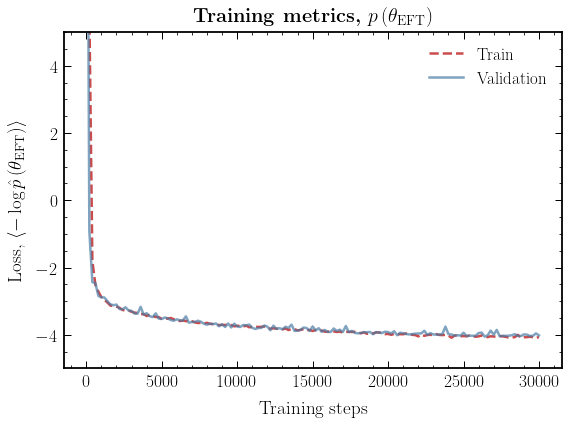

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(steps_accum, loss_train_accum, label="Train", ls='--')
ax.plot(steps_accum, loss_val_accum, label="Validation", alpha=0.7)
ax.set_xlabel("Training steps")
ax.set_ylabel(r"Loss, $\langle -\log \hat p\left(\theta_\mathrm{EFT}\right)\rangle$")

ax.legend()
ax.set_title(r"\bf{Training metrics, $p\left(\theta_\mathrm{EFT}\right)$}", y=1.01, fontsize=20)

ax.set_ylim(-5, 5)

plt.tight_layout()
plt.savefig("figures/loss_p_eft.pdf")

In [39]:
samples = flow.sample(num_samples=100_000)

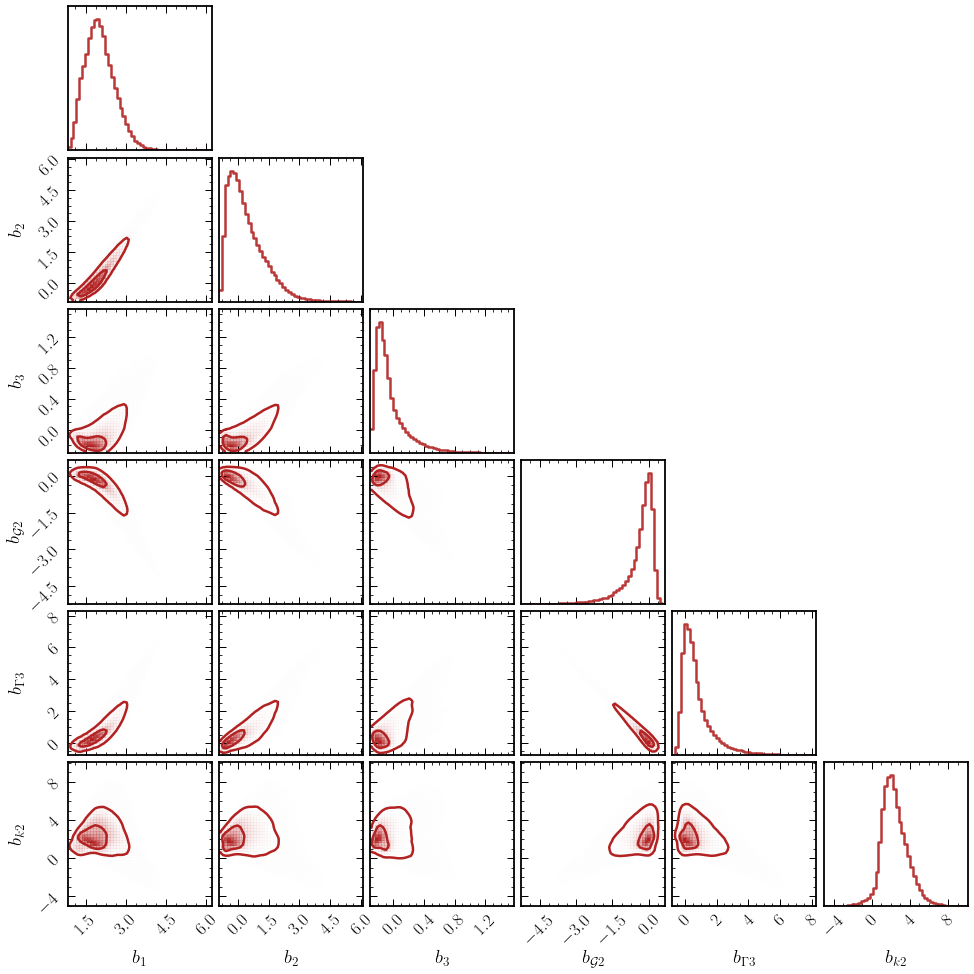

In [40]:
levels =  1.0 - np.exp(-0.5 *np.array([1.0, 2.0]) ** 2)

corner_configs = {
    "smooth": 0.75,
    "smooth1d": 0.5,
    "bins": 50,
    "levels": levels, # Assuming 'levels' is defined elsewhere
    "plot_datapoints": False,
    "plot_density": True,
    "labels": [r'$b_1$', r'$b_2$', r'$b_3$', r'$b_{\mathcal G2}$', r'$b_{\Gamma3}$', r'$b_{k2}$']
}

fig = corner.corner(samples.detach().numpy(), **corner_configs, color='firebrick');

In [41]:
torch.save(flow, "../data/models/p_beta.pt")